In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dropout
from sklearn.model_selection import train_test_split
import zipfile
import os
import cv2

import tarfile
import sys
import h5py
from six.moves import cPickle as pickle
from PIL import Image

%matplotlib inline

In [0]:
import h5py

# The DigitStructFile is just a wrapper around the h5py data.  It basically references
#    input:              The input h5 matfile
#    digitStruct_name:   The h5 ref to all the file names
#    digitStruct_bbox:   The h5 ref to all struc data

class DigitStructFile:
    def __init__(self, input):
        self.input = h5py.File(input, 'r')
        self.digitStruct_name = self.input['digitStruct']['name']
        self.digitStruct_bbox = self.input['digitStruct']['bbox']

    # get_name returns the 'name' string for the n(th) digitStruct.

    def get_name(self,n):
        return ''.join([chr(c[0]) for c in self.input[self.digitStruct_name[n][0]].value])

    def bbox_helper(self,attribute):
        if (len(attribute) > 1):
            attribute = [self.input[attribute.value[j].item()].value[0][0] for j in range(len(attribute))]
        else:
            attribute = [attribute.value[0][0]]
        return attribute

    # get_bbox returns a 'dict' of data for the n(th) bbox.
    def get_bbox(self,n):
        bbox = {}
        bb = self.digitStruct_bbox[n].item()
        bbox['height'] = self.bbox_helper(self.input[bb]["height"])
        bbox['label']  = self.bbox_helper(self.input[bb]["label"])
        bbox['left']   = self.bbox_helper(self.input[bb]["left"])
        bbox['top']    = self.bbox_helper(self.input[bb]["top"])
        bbox['width']  = self.bbox_helper(self.input[bb]["width"])
        return bbox

    def get_DigitStructure(self,n):
        s = self.get_bbox(n)
        s['name']=self.get_name(n)
        return s

    # get_all_DigitStructure returns all the digitStruct from the input file.
    def get_all_DigitStructure(self):
        return [self.get_DigitStructure(i) for i in range(len(self.digitStruct_name))]
        
# Return a restructured version of the dataset (one structure by boxed digit).
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#      'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#      'left', 'top' : position of bounding box
#      'width', 'height' : dimension of bounding box

    def get_all_DigitStructure_ByDigit(self):
        img_data = self.get_all_DigitStructure()
        result = []
        struct_count = 1
        for i in range(len(img_data)):
            item = { 'filename' : img_data[i]["name"] }
            figures = []
            for j in range(len(img_data[i]['height'])):
                figure = {}
                figure['height'] = img_data[i]['height'][j]
                figure['label']  = img_data[i]['label'][j]
                figure['left']   = img_data[i]['left'][j]
                figure['top']    = img_data[i]['top'][j]
                figure['width']  = img_data[i]['width'][j]
                figures.append(figure)
            struct_count += 1
            item['boxes'] = figures
            result.append(item)
        return result


In [22]:
"""
train_file = ('/content/drive/My Drive/SVHN/train.tar.gz')
test_file = ('/content/drive/My Drive/SVHN/test.tar.gz')
"""

"\ntrain_file = ('/content/drive/My Drive/SVHN/train.tar.gz')\ntest_file = ('/content/drive/My Drive/SVHN/test.tar.gz')\n"

In [23]:
"""
def extract_afile(filename):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root):
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    data_folders = root
    print(data_folders)
    return data_folders
  
train_folders = extract_afile(train_file)
test_folders = extract_afile(test_file)
"""

"\ndef extract_afile(filename):\n    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz\n    if os.path.isdir(root):\n        print('%s already present - Skipping extraction of %s.' % (root, filename))\n    else:\n        print('Extracting data for %s. This may take a while. Please wait.' % root)\n        tar = tarfile.open(filename)\n        sys.stdout.flush()\n        tar.extractall()\n        tar.close()\n    data_folders = root\n    print(data_folders)\n    return data_folders\n  \ntrain_folders = extract_afile(train_file)\ntest_folders = extract_afile(test_file)\n"

In [0]:
with zipfile.ZipFile("/content/drive/My Drive/Data Science/SVHN/street-view-house-numbers.zip") as file:
  file.extractall("")

In [0]:
dsf = DigitStructFile("/content/train_digitStruct.mat")
train_data = dsf.get_all_DigitStructure_ByDigit()

print('Train ready')


dsf = DigitStructFile("/content/test_digitStruct.mat")
test_data = dsf.get_all_DigitStructure_ByDigit()

print('Test ready')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


In [0]:
pickle_file = 'train_data.pickle'

with open(pickle_file, 'wb') as f:
  pickle.dump(train_data, f, pickle.HIGHEST_PROTOCOL)


pickle_file = 'test_data.pickle'

f = open(pickle_file, 'wb')
pickle.dump(test_data, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [0]:
train_folders = 'train'
test_folders = 'test'

pickle_name = 'train_data.pickle'

with open(pickle_name, 'rb') as f:
    train_data = pickle.load(f)
    
pickle_name = 'test_data.pickle'

with open(pickle_name, 'rb') as f:
    test_data = pickle.load(f)

In [0]:
img_names = []
for i in range(len(train_data)):
  img = train_data[i]['filename']
  img_names.append(img)

In [0]:
labels = ['']*len(train_data)
for i in range(len(train_data)):
  for j in range(len(train_data[i]['boxes'])):
    if train_data[i]['boxes'][j]['label'] == float(10):
      train_data[i]['boxes'][j]['label'] = float(0)

    labels[i] += str(int(train_data[i]['boxes'][j]['label']))

print(labels)

In [0]:
int_labels = []

for i in range(0,len(labels)):
    labels[i]=int(labels[i])
    int_labels.append(labels[i])
print(int_labels)

In [0]:
"""
i=0
new_list=[]
while i<len(int_labels):
  new_list.append(int_labels[i:i+1])
  i+=1

print(new_list)
"""

'\ni=0\nnew_list=[]\nwhile i<len(int_labels):\n  new_list.append(int_labels[i:i+1])\n  i+=1\n\nprint(new_list)\n'

In [18]:
import cv2
img = cv2.imread('/content/train/749.png')
#img = img.astype(int)
img = cv2.resize(img,(256,256))

error: ignored

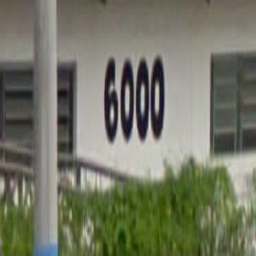

In [0]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)


In [0]:
img = np.array(img)[indices.astype(int)]

In [14]:
images_name = img_names
X = []
#Y = []
for i in range(len(images_name)):
  try:
    #print('/content/train/'+ images_name[i])
    img = cv2.imread('/content/train/'+ images_name[i])
    #img = np.array(img)[indices.astype(int)]
    img = cv2.resize(img,(256,256))
    #print(img)
    #y = digit_struct['digitStruct']['bbox'][i]['label']
    #X.append(img)
    #Y.append(y)
  except:
    print(images_name[i])
    pass

Streaming output truncated to the last 5000 lines.
12350.png
12351.png
12352.png
12353.png
12354.png
12355.png
12356.png
12357.png
12358.png
12359.png
12360.png
12361.png
12362.png
12363.png
12364.png
12365.png
12366.png
12367.png
12368.png
12369.png
12370.png
12371.png
12372.png
12373.png
12374.png
12375.png
12376.png
12377.png
12378.png
12379.png
12380.png
12381.png
12382.png
12383.png
12384.png
12385.png
12386.png
12387.png
12388.png
12389.png
12390.png
12391.png
12392.png
12393.png
12394.png
12395.png
12396.png
12397.png
12398.png
12399.png
12400.png
12401.png
12402.png
12403.png
12404.png
12405.png
12406.png
12407.png
12408.png
12409.png
12410.png
12411.png
12412.png
12413.png
12414.png
12415.png
12416.png
12417.png
12418.png
12419.png
12420.png
12421.png
12422.png
12423.png
12424.png
12425.png
12426.png
12427.png
12428.png
12429.png
12430.png
12431.png
12432.png
12433.png
12434.png
12435.png
12436.png
12437.png
12438.png
12439.png
12440.png
12441.png
12442.png
12443.png
12444.png

KeyboardInterrupt: ignored

In [0]:
Y = int_labels

In [0]:
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
